In [1]:
# First step is to import all of the necessary libraries for this experiment

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 

# Checking tensorflow version
if float(tf.__version__[0]) < 2.0:
    print("Updating Tensorflow")
    !pip install --upgrade tensorflow
else: 
    print("Correct Version of Tensorflow installed")
    
print('TF Version: ', tf.__version__)
print('Pandas Version: ',pd.__version__)
print('Numpy Version: ',np.__version__)

Correct Version of Tensorflow installed
TF Version:  2.4.1
Pandas Version:  1.1.5
Numpy Version:  1.19.5


In [2]:
data = pd.read_csv('/raid/tft-data/data/combined_news.csv')

In [3]:
# converting labels from strings to ints
data["label"].replace({"Real": 1, "Fake": 0}, inplace=True)

In [4]:
# Tokenizing Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)

# Padding data
# Keras prefers inputs to be vectorized and all inputs to have the same length. 
# We will pad all input sequences to have the length. We will pad all input sequences to have specific length
sequences = tokenizer.texts_to_sequences(data['text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [5]:
# Compartmentalizing data into training set and testing set
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = data['label'].values[:split_n]
test_data = padded[split_n:]
test_labels = data['label'].values[split_n:] 

In [6]:
# Using Pre-Trained GloVe for Keras embedding layer
embeddings_index = {};
with open('/raid/tft-data/Glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


In [7]:
# Temporary model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
# Training model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=2, batch_size=100, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         13802200  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

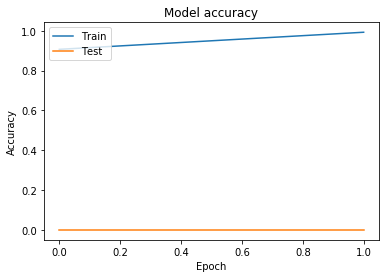

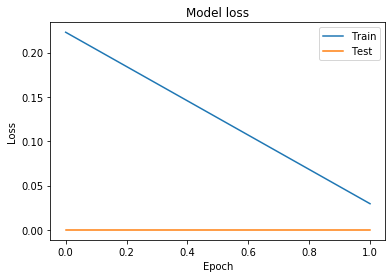

In [9]:
# Visualizing the Results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()